In [12]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

## MSEIRS Equations
Reference: 
- https://www.freecodecamp.org/news/how-to-model-an-epidemic-with-r/ 
- https://repositorium.sdum.uminho.pt/bitstream/1822/60583/1/preprint.pdf

In our MSEIRS system, we make the below assumptions:
1. The death rate and born rate are the same, which means the number of population will not change over time.
2. Both passive maternally-derived immunity and temporary immunity weakened at the same rate

In [13]:
# define the SEIR function
def MSEIRS_vaccination(time, current_state, lam, delta, start_time):
    M, S, V, E, I, R = current_state
    
    beta = 0.5
    sigma = 0.25
    gamma = 0.2
    alpha = 0
    epsilon = 0
    
    # if vaccine starts, reset beta and sigma values
    if time >= start_time:
        beta -= 0.05
        sigma -= 0.05
        gamma += 0.05
        # 6,000 people are vaccinated per day
        alpha = 0.006
        # Of all people vaccinated, 80% will be immune to the disease while 20% are not
        epsilon = 0.8
    
    N = M + S + V + E + I + R
    
    # -weakend rate * infant with immunity + new born rate * new born with immunity prob
    dM = -delta * M + lam * I * R / N
    # - contact rate * contact probabilities 
    # + new born losing passive immunity rate 
    # + new born rate * new born without immunity prob
    # - vaccine rate * vaccine efficiency * S
    dS = -(beta * S * I) / N + delta * M + lam * I * (1 - R / N) + delta * R - alpha * epsilon * S
    
    dV = alpha * epsilon * S - (beta * V * I) / N
    
    # + Vaccinated individual
    dE = (beta * S * I) / N - sigma * E + (beta * V * I) / N
    
    # infectious rate - recovery rate - death rate
    dI = sigma * E - gamma * I - lam * I
    
    # recovery rate + immunity weakened rate
    dR = gamma * I - delta * R
    
    return [dM, dS, dV, dE, dI, dR]

## Initial Parameters
beta : Transmission/Contact rate  
sigma : Infectious rate  
gamma : Recovery rate  
delta : Immunity weakened rate  
lambda : Birth/Death rate 
days : Number of days to simulate

In [14]:
# Set the parameters
lam = 0.05
delta = 0.1

# Start of intervention
start_time = 90

# Set the time points for simulation
times = np.arange(0, 366)

## S - Susceptible, E - Exposed, I - Infectious, R - Recovered
M = 0: The initial number of new born with maternal immunity is set to 0.  
S = 999999: The initial number of susceptible individuals is set to 999,999.  
V = 0: The initial number of vaccinated individuals is set to 0.  
E = 1: The initial number of exposed individuals is set to 1.  
I = 0: The initial number of infectious individuals is set to 0.  
R = 0: The initial number of recovered individuals is set to 0.  

In [15]:
# initialise the initialise state of SEIR
initial_state = [0, 999999, 0, 1, 0, 0]

## solve_ivp
To solve equation with respect to time

In [16]:
from scipy.integrate import solve_ivp

In [17]:
# Solve the SEIR model using solve_ivp
solution = solve_ivp(lambda t, 
                    y: MSEIRS_vaccination(t, y, lam, delta, start_time), 
                    [times[0], times[-1]], 
                    initial_state, t_eval=times)

## Summary of model's statistics

In [22]:
# num_scenarios = len(intervention_scenarios)
# Create an empty DataFrame with column names
df = pd.DataFrame(columns=['Compartment', 'Mean', 'Min', 'Max', '25th', '50th', '75th'])

# Access the solution arrays
M = solution.y[0]
S = solution.y[1]
V = solution.y[2]
E = solution.y[3]
I = solution.y[4]
R = solution.y[5]

# Calculate summary statistics
summary_M = np.mean(M), np.min(M), np.max(M), np.percentile(M, [25, 50, 75])
summary_S = np.mean(S), np.min(S), np.max(S), np.percentile(S, [25, 50, 75])
summary_V = np.mean(V), np.min(V), np.max(V), np.percentile(V, [25, 50, 75])
summary_E = np.mean(E), np.min(E), np.max(E), np.percentile(E, [25, 50, 75])
summary_I = np.mean(I), np.min(I), np.max(I), np.percentile(I, [25, 50, 75])
summary_R = np.mean(R), np.min(R), np.max(R), np.percentile(R, [25, 50, 75])

list_summary = [summary_M, summary_S, summary_V, summary_E, summary_I, summary_R]
summary_names = ['M', 'S', 'V', 'E', 'I', 'R']

nrow = 0
for i in range(len(list_summary)):
    # Add data row by row using DataFrame.loc
    df.loc[nrow] = [summary_names[i], 
                    list_summary[i][0], list_summary[i][1], list_summary[i][2], 
                     list_summary[i][3][0], list_summary[i][3][1], list_summary[i][3][2]]
    nrow += 1

df

,Compartment,Mean,Min,Max,25th,50th,75th
0,M,2930.143426,0.000000,5427.261633,3.118073,4161.338056,5377.691454
1,S,715056.886843,548357.416344,999999.000000,570975.832196,573306.576199,979879.528514
2,V,80522.309811,0.000000,165357.788341,5584.915913,93948.260661,108176.298012
3,E,62384.105070,0.763966,99870.507185,6131.933838,98258.834282,98409.108338
4,I,41046.106459,0.000000,66596.155590,3897.111975,65199.959198,65634.285711
5,R,98060.448392,0.000000,165243.449110,4503.391688,151779.820100,163981.650621


In [19]:
# Extract rows based on a condition
comp_lst = ['S', 'V', 'I', 'R']

for i in range(len(comp_lst)):
    df_extract = df[df['Compartment'] == comp_lst[i]]
    print(df_extract[['Intervention', 'Compartment', 'Min', 'Max']])

  Intervention Compartment            Min       Max
1  Vaccination           S  548357.416344  999999.0
  Intervention Compartment  Min            Max
2  Vaccination           V  0.0  165357.788341
  Intervention Compartment  Min          Max
4  Vaccination           I  0.0  66596.15559
  Intervention Compartment  Min           Max
5  Vaccination           R  0.0  165243.44911


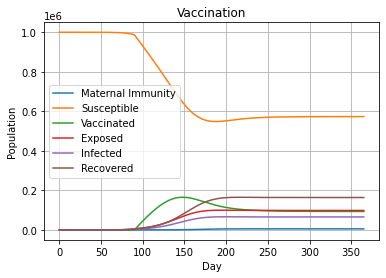

In [20]:
# Plot   
plt.plot(times, M, label='Maternal Immunity')
plt.plot(times, S, label='Susceptible')
plt.plot(times, V, label='Vaccinated')
plt.plot(times, E, label='Exposed')
plt.plot(times, I, label='Infected')
plt.plot(times, R, label='Recovered')
plt.xlabel('Day')
plt.ylabel('Population')
plt.title("Vaccination")
plt.legend()
plt.grid(True)
plt.show()

## Percentage change

In [25]:
pct_S = (summary_S[1] - 477812)/477812 * 100
pct_I = (summary_I[2] - 134301)/134301 * 100
# pct_R = (summary_R[2] - 252928)/252928 * 100

print('% change of not infected:', round(pct_S, 2))
print('% change of infected:', round(pct_I, 2))

% change of not infected: 14.76
% change of infected: -50.41
